## Goals

The goal of the coding part of this homework assignment is to practice the process of tuning hyperparameters to find a good neural network model.

We will work with the same Reuters newswires data set from the last homework.  In that assignment, we accepted the model that Chollet used in the book.  Here we will see if we can improve that model at all.

## Module Imports
You don't need to make any changes to this code, just run it.

In [0]:
from keras import models
from keras import layers
from keras import optimizers
from keras import regularizers
from keras.datasets import reuters
import matplotlib.pyplot as plt
import numpy as np
import copy

## Load data

You don't need to make any changes to this code, just run it.

In [0]:
(train_and_val_data, train_and_val_labels), (test_data, test_labels) = reuters.load_data(
    num_words=10000)

def vectorize_sequences(sequences, dimension=10000):
    results = np.zeros((len(sequences), dimension))
    for i, sequence in enumerate(sequences):
        results[i, sequence] = 1.
    return results

x_train_and_val = vectorize_sequences(train_and_val_data)
x_test = vectorize_sequences(test_data)

def to_one_hot(labels, dimension=46):
    results = np.zeros((len(labels), dimension))
    for i, label in enumerate(labels):
        results[i, label] = 1.
    return results

one_hot_train_and_val_labels = to_one_hot(train_and_val_labels)
y_train_and_val = one_hot_train_and_val_labels

one_hot_test_labels = to_one_hot(test_labels)
y_test = one_hot_test_labels

x_val = x_train_and_val[:1000]
x_train = x_train_and_val[1000:]

y_val = one_hot_train_labels[:1000]
y_train = one_hot_train_labels[1000:]

## Chollet's Model
You don't have to do anything here other than run the code below.  This is our baseline model, from the book.

In [0]:
chollet_model = models.Sequential()
chollet_model.add(layers.Dense(64, activation='relu', input_shape=(10000,)))
chollet_model.add(layers.Dense(64, activation='relu'))
chollet_model.add(layers.Dense(46, activation='softmax'))

In [11]:
chollet_model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

history = chollet_model.fit(x_train,
                    y_train,
                    epochs=20,
                    batch_size=512,
                    validation_data=(x_val, y_val))

Train on 7982 samples, validate on 1000 samples
Epoch 1/20
7982/7982 [==============================] - 1s 131us/step - loss: 2.5443 - acc: 0.5405 - val_loss: 1.6874 - val_acc: 0.6520
Epoch 2/20
7982/7982 [==============================] - 0s 55us/step - loss: 1.3742 - acc: 0.7093 - val_loss: 1.2770 - val_acc: 0.7180
Epoch 3/20
7982/7982 [==============================] - 0s 55us/step - loss: 1.0264 - acc: 0.7757 - val_loss: 1.1146 - val_acc: 0.7500
Epoch 4/20
7982/7982 [==============================] - 0s 54us/step - loss: 0.8105 - acc: 0.8267 - val_loss: 1.0324 - val_acc: 0.7810
Epoch 5/20
7982/7982 [==============================] - 0s 55us/step - loss: 0.6437 - acc: 0.8613 - val_loss: 0.9676 - val_acc: 0.7920
Epoch 6/20
7982/7982 [==============================] - 0s 54us/step - loss: 0.5149 - acc: 0.8887 - val_loss: 0.9308 - val_acc: 0.8110
Epoch 7/20
7982/7982 [==============================] - 0s 57us/step - loss: 0.4186 - acc: 0.9085 - val_loss: 0.9275 - val_acc: 0.8150
Epoch 

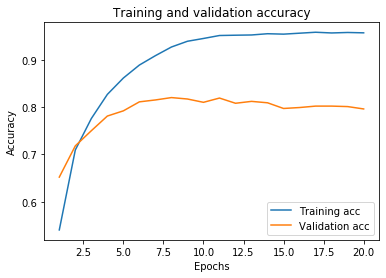

In [12]:
acc = history.history['acc']
val_acc = history.history['val_acc']

epochs = range(1, len(acc) + 1)


plt.plot(epochs, acc, label='Training acc')
plt.plot(epochs, val_acc, label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

The validation set accuracy of this model ended up at about 0.8, and is well below the training set accuracy.  We'll try to find a combination of hyperparameters with better validation set accuracy, and then refit both our final model and Chollet's model to the full combined training and validation set data and evaluate their performance on the test set.

## Hyperparameter tuning, adding regularization

We have a pretty good model with some evidence that it is overfitting the training data.  Let's see if we can tune some of the hyperparameters of the model to achieve better validation set accuracy.  We will consider adding regularization using an $L_2$ penalty and/or dropout.  In this case, the size of our input layer (10000 features) is much larger than the size of our hidden layers, so it seems possible that we'd want to use dropout on the input layer, potentially with a different (larger?) dropout rate than the dropout rate for the hidden layers.  This means we will have three hyperparameters to pick: (1) dropout rate for the input layer; (2) dropout rate for the hidden layers; and (3) the penalty for $L_2$ regularization, applied to both hidden layers.  Let's use random search to explore performance of models with different values of these three hyperparameters.

To do that, we will need to:

 * randomly generate sets of values for each of these hyperparameters.  Let's generate 8 sets of values; this should be enough to give a sense of which hyperparameters have the biggest impact on performance of this model without taking forever to fit (it will take long enough with just 8).
 * Specify and fit a model with each combination of hyperparameter settings, and save the validation set accuracy.

#### 1. Random generation of hyperparameter values.

 * Common values for the dropout rate are between 0.0 (no dropout) and 0.5.  However, the size of our input features is so large that it seems possible we would want an even larger dropout rate on the input layer; let's consider values between 0.0 and 0.9 for the input layer (but note that dropout rates this large are unusual).  You can generate these uniformly at random in these intervals using the np.random.uniform function.  You want 8 of them, so set your size appropriately.
 * Common values for the penalty parameter $\lambda$ are from about 0 (no $L_2$ penalty) to 0.1.  However, the effect of the penalty does not scale linearly: the effect on model performance of going from a penalty of $\lambda = 0.0001$ to $\lambda = 0.0002$ is larger than the effect of going from $\lambda = 0.01$ to $\lambda = 0.0101$ (though to be honest the relationship looked pretty close to linear in my results).  This means we would like to explore more values of $\lambda$ near 0 than near 0.1.  We can do this by working on a logarithmic scale.  We will:
    * First, generate exponents $u$ uniformly distributed between -6 and -1.  You want 8 of these.
    * Second, set the values of $\lambda$ to try to $10^{u}$.  In this way, our values of lambda will be between $10^{-6}$ and $10^{-1}$, with more values closer to $10^{-6}$.

We'll assume that Chollet did a pretty thorough exporation of the number of layers and number of units per layer, and keep those hyperparameters fixed.  We'll also stick with the rmsprop optimizer with batch size of 512 he used.

**In order for the code I have provided in the next part to work, your input_dropout_rates, hidden_dropout_rates, and l2_penalties should be one-dimensional arrays.  This means you should use size (8,) instead of something like (8.1).**

In [49]:
# Setting a seed so we all get comparable results
np.random.seed(64730)

# Generate dropout rates for the input layer:
# 8 numbers uniformly distributed from 0 to 0.9
input_dropout_rates = np.random.uniform(low = 0.0, high = 0.9, size = (8,))
print("input dropout rates = " + str(input_dropout_rates))

# Generate dropout rates for the hidden layers:
# 8 numbers uniformly distributed from 0 to 0.5
hidden_dropout_rates = np.random.uniform(low = 0.0, high = 0.5, size = (8,))
print("hidden dropout rates = " + str(hidden_dropout_rates))

# Generate L_2 penalty parameters, in two stages:
# u should be uniformly distributed from -6 to -1
# then l2_penalties is 10 to the power of u
# Note that in python, lambda is a reserved keyword so it's best to use a
# different name, which is why I've gone with l2_penalties here
u = np.random.uniform(low = -6, high = -1, size = (8,))
l2_penalties = 10**u
print("l2_penalties = " + str(l2_penalties))

input dropout rates = [0.72807915 0.78121579 0.33759414 0.60574263 0.43113313 0.17192187
 0.41814111 0.78693711]
hidden dropout rates = [0.30954935 0.09599261 0.06038929 0.03211626 0.43386078 0.01608936
 0.48785323 0.40673594]
l2_penalties = [1.17703389e-06 8.94505148e-05 1.94648204e-05 4.16051385e-03
 2.23930277e-05 1.49160276e-06 7.48310905e-03 2.21459085e-04]


#### 2. Fit models and save validation set performance for each

Write and code below to define and fit all 8 of your models with different values for the dropout rates and $L_2$ penalty parameter lambda.

 * Use dropout on the input layer as well as each hidden layer
 * Use 64 units and a relu activation for all hidden layers
 * Because regularization can slow down getting a good fit to the training data, let's use 100 epochs instead of 20.

This will take several minutes to run.

In [50]:
val_acc = np.zeros((8,))

for (i, input_dropout_rate, hidden_dropout_rate, l2_penalty) in \
  zip(range(8), input_dropout_rates, hidden_dropout_rates, l2_penalties):
  # define model
  model = models.Sequential()

  # add dropout layer for inputs, with its input_dropout_rate
  model.add(layers.Dropout(rate = input_dropout_rate))

  # add first hidden layer with L2 regularization and another dropout layer
  model.add(layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(l = l2_penalty), input_shape=(10000,)))
  model.add(layers.Dropout(rate = hidden_dropout_rate))

  # add second hidden layer with L2 regularization and another dropout layer
  model.add(layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(l = l2_penalty)))
  model.add(layers.Dropout(rate = hidden_dropout_rate))

  # add output layer
  model.add(layers.Dense(46, activation='softmax'))

  # compile model
  model.compile(optimizer='rmsprop',
                loss='categorical_crossentropy',
                metrics=['accuracy'])
  
  # fit model using x_train and y_train, 100 epochs, a batch_size of 512, and
  # validation_data = (x_val, y_val)
  history = model.fit(x_train,
                      y_train,
                      epochs=100,
                      batch_size=512,
                      validation_data=(x_val, y_val))
  
  # save the validation set classification accuracy after 100 epochs
  val_acc[i] = history.history['val_acc'][-1]

Train on 7982 samples, validate on 1000 samples
Epoch 1/100
7982/7982 [==============================] - 4s 502us/step - loss: 3.0310 - acc: 0.3502 - val_loss: 2.1354 - val_acc: 0.5470
Epoch 2/100
7982/7982 [==============================] - 1s 63us/step - loss: 2.1406 - acc: 0.5125 - val_loss: 1.6954 - val_acc: 0.5960
Epoch 3/100
7982/7982 [==============================] - 1s 63us/step - loss: 1.8626 - acc: 0.5585 - val_loss: 1.5388 - val_acc: 0.6400
Epoch 4/100
7982/7982 [==============================] - 1s 65us/step - loss: 1.7217 - acc: 0.5912 - val_loss: 1.4298 - val_acc: 0.6680
Epoch 5/100
7982/7982 [==============================] - 1s 63us/step - loss: 1.6255 - acc: 0.6160 - val_loss: 1.3368 - val_acc: 0.6760
Epoch 6/100
7982/7982 [==============================] - 1s 63us/step - loss: 1.5381 - acc: 0.6443 - val_loss: 1.2713 - val_acc: 0.7050
Epoch 7/100
7982/7982 [==============================] - 0s 61us/step - loss: 1.4729 - acc: 0.6577 - val_loss: 1.2202 - val_acc: 0.7220

#### 3. Make scatter plots showing how validation accuracy varies with the hyperparameter values.

You should make three scatter plots: one showing val_acc vs input_dropout_rates; a second showing val_acc vs hidden_dropout_rates; and a third showing val_acc vs l2_penalties

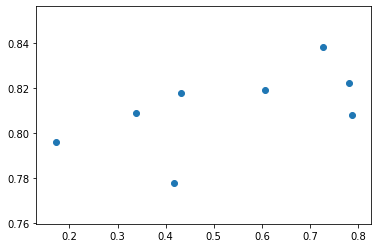

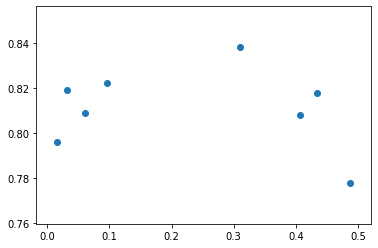

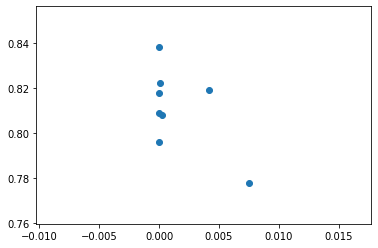

In [51]:
plt.scatter(input_dropout_rates, val_acc)
plt.show()
plt.scatter(hidden_dropout_rates, val_acc)
plt.show()
plt.scatter(l2_penalties, val_acc)
plt.show()

#### 4. Based on the scatter plots in part 3, which hyperparameter settings seem best?  Please pick a specific number for each hyperparameter.  We don't know the exact best values, but we can make a good enough determination.

(put your answer here)

#### 5. Suppose we had used a grid search with 8 combinations of parameter settings instead of the random search procedure with 8 combinations.  How many unique values would we have been able to try for each of the three hyperparameters?  Would the results have given us as good of a view of how model performance depended on each model parameter as what we saw here?

(put your answer here)

## Refit models to the combined training and validation set data
When we are making test set predictions, we want to do so with a model that was fit using as much data as possible.

### Chollet's Model

You don't need to do anything here other than run the code.

In [16]:
history = chollet_model.fit(x_train_and_val,
                    y_train_and_val,
                    epochs=20,
                    batch_size=512)

Epoch 1/20
8982/8982 [==============================] - 0s 46us/step - loss: 0.2128 - acc: 0.9418
Epoch 2/20
8982/8982 [==============================] - 0s 46us/step - loss: 0.1675 - acc: 0.9481
Epoch 3/20
8982/8982 [==============================] - 0s 47us/step - loss: 0.1514 - acc: 0.9506
Epoch 4/20
8982/8982 [==============================] - 0s 45us/step - loss: 0.1317 - acc: 0.9520
Epoch 5/20
8982/8982 [==============================] - 0s 47us/step - loss: 0.1276 - acc: 0.9538
Epoch 6/20
8982/8982 [==============================] - 0s 46us/step - loss: 0.1217 - acc: 0.9537
Epoch 7/20
8982/8982 [==============================] - 0s 47us/step - loss: 0.1178 - acc: 0.9552
Epoch 8/20
8982/8982 [==============================] - 0s 48us/step - loss: 0.1141 - acc: 0.9552
Epoch 9/20
8982/8982 [==============================] - 0s 46us/step - loss: 0.1145 - acc: 0.9544
Epoch 10/20
8982/8982 [==============================] - 0s 47us/step - loss: 0.1115 - acc: 0.9557
Epoch 11/20
8982/89

In [17]:
chollet_model.evaluate(x_test, y_test)

2246/2246 [==============================] - 0s 80us/step


[1.3978797875656577, 0.783615316064466]

#### 6. Refit your final model to the combined training and validation set data

You will need to redefine and refit your model using the hyperparameter settings you selected in part 4.  You should be fitting to x_train_and_val and y_train_and_val using rmsprop with 100 epochs and a batch size of 512.

In [52]:
final_model = models.Sequential()

final_model.add(layers.Dropout(rate = 0.75))
final_model.add(layers.Dense(64, activation='relu', input_shape=(10000,)))
final_model.add(layers.Dropout(rate = 0.3))
final_model.add(layers.Dense(64, activation='relu'))
final_model.add(layers.Dropout(rate = 0.3))
final_model.add(layers.Dense(46, activation='softmax'))

final_model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

history = final_model.fit(x_train_and_val,
                    y_train_and_val,
                    epochs=100,
                    batch_size=512)

Epoch 1/100
8982/8982 [==============================] - 4s 486us/step - loss: 2.9893 - acc: 0.3831
Epoch 2/100
8982/8982 [==============================] - 1s 60us/step - loss: 2.1302 - acc: 0.5156
Epoch 3/100
8982/8982 [==============================] - 1s 58us/step - loss: 1.8566 - acc: 0.5627
Epoch 4/100
8982/8982 [==============================] - 1s 59us/step - loss: 1.7146 - acc: 0.6087
Epoch 5/100
8982/8982 [==============================] - 1s 62us/step - loss: 1.6050 - acc: 0.6278
Epoch 6/100
8982/8982 [==============================] - 1s 60us/step - loss: 1.5151 - acc: 0.6466
Epoch 7/100
8982/8982 [==============================] - 1s 61us/step - loss: 1.4704 - acc: 0.6562
Epoch 8/100
8982/8982 [==============================] - 1s 62us/step - loss: 1.4134 - acc: 0.6706
Epoch 9/100
8982/8982 [==============================] - 1s 60us/step - loss: 1.3546 - acc: 0.6820
Epoch 10/100
8982/8982 [==============================] - 1s 61us/step - loss: 1.3184 - acc: 0.6888
Epoch 11

#### 7. Find the test set performance of your final model.

In [53]:
final_model.evaluate(x_test, y_test)

2246/2246 [==============================] - 2s 824us/step


[0.9153138020159619, 0.811665182599826]

#### 8. Discuss the relative performance of Chollet's model and your final model on the combined training/validation set and on the test set.  Does it seem like you have addressed the problem of overfitting the training data?  Which model is better?  (You need at least one sentence for each of these questions.)

(put your answer here)